# ITAM - Maestría en Ciencia de Datos
# Métodos a Gran Escala
# Tarea 02

Edgar Daniel Diaz Nava (174415)

## Resumen


### Contexto

* Supon que estamos trabajando en una start up de bienes raices y necesitamos
construir un producto de datos que ayude a soportar una aplicación para
que nuestros clientes (compradores/vendedores) puedan consultar una estimación
del valor de una propiedad de bienes raíces.

* Aún el CEO no tiene claro como debe de diseñarse esta aplicación. Nostros
como data scientists debemos proponer una Prueba de Concepto, que permita
experimentar rápido, dar un *look an feel* de la experiencia y nos permita
fallar rápido para probar una siguiente iteración.

In [ ]:
# Instalamos paquetes necesarios

!pip install lightgbm --quiet

In [ ]:
# Importamos librerias necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import ipywidgets as widgets
from IPython.display import display

# Definimos el estilo de las gráficas
plt.style.use('ggplot')

In [ ]:
# Parametros y constantes

FEATURES_FILE_NAME = "sales_features.csv"
MODEL_FILE_NAME = "lightgbm_model_trained.txt"

In [ ]:
# Importamos los datos a explorar

item_categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
sales_train = pd.read_csv("sales_train.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

sample_submission = pd.read_csv("sample_submission.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'item_categories.csv'

### Funciones

In [ ]:
def hist_plot(df, x_col, title="", xlabel="", ylabel="", figsize=(8,5), color="black"):
    """
    Genera un gráfico lineal minimalista usando Pandas y Matplotlib.

    Parámetros:
    -----------
    df : pandas.DataFrame
        El DataFrame que contiene los datos a representar.

    x_col : str
        El nombre de la columna a utilizar para el eje x.

    y_col : str
        El nombre de la columna a utilizar para el eje y.

    title : cadena, opcional, por defecto="»
        Título del gráfico.

    xlabel : str, opcional, por defecto="»
        Etiqueta del eje x.

    ylabel : str, opcional, por defecto="»
        Etiqueta del eje y.

    figsize : tupla, opcional, por defecto=(8,5)
        El tamaño de la figura en pulgadas (ancho, alto).

    color : str, opcional, por defecto="negro»
        El color de la línea.

    Devuelve:
    --------
    Ninguno
        Muestra el gráfico.

    Ejemplo:
    --------
    >>> df = pd.DataFrame({'Fecha': pd.date_range(start='2024-01-01', periods=10),
    ...                    'Ventas': [10, 15, 13, 18, 20, 22, 21, 25, 28, 30]})
    >>> minimal_pandas_plot(df, x_col='Fecha', y_col='Ventas', title='Tendencia de ventas')
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the data
    plt.hist(df[x_col], color = color,  fill=color, rwidth = 0.7)

    # Minimalist design tweaks
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("gray")
    ax.spines["bottom"].set_color("gray")

    ax.tick_params(axis="both", which="both", bottom=True, left=True, direction="out", length=5, color="gray")

    # Labels and title
    ax.set_title(title, fontsize=14, fontweight="bold", pad=10)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)



    plt.show()

def minimal_bar_plot(df, column, title="", xlabel="", ylabel="Count", figsize=(8,5), color="black"):
    """
    Genera un gráfico de barras minimalista que muestra el recuento de valores únicos en una columna especificada.

    Parámetros:
    -----------
    df : pandas.DataFrame
        El DataFrame que contiene los datos.

    columna : str
        El nombre de la columna para la que se trazarán los recuentos de valores únicos.

    title : str, opcional, por defecto="»
        Título del gráfico.

    xlabel : str, opcional, por defecto="»
        Etiqueta del eje x.

    ylabel : str, opcional, por defecto="Count»
        Etiqueta del eje y.

    figsize : tupla, opcional, por defecto=(8,5)
        El tamaño de la figura en pulgadas (ancho, alto).

    color : str, opcional, por defecto="negro»
        El color de las barras.

    Devuelve:
    --------
    Ninguno
        Muestra el gráfico.

    Ejemplo:
    --------
    >>> df = pd.DataFrame({'Categoría': ['A', 'B', 'A', 'C', 'B', 'B', 'A', 'C', 'A', 'C']})
    >>> minimal_bar_plot(df, column='Categoría', title='Distribución por categorías')
    """
    # Count unique values
    value_counts = df[column].value_counts()

    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Create bar plot
    value_counts.plot(kind="bar", color=color, ax=ax)

    # Minimalist design tweaks
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("gray")
    ax.spines["bottom"].set_color("gray")

    ax.tick_params(axis="both", which="both", bottom=True, left=True, direction="out", length=5, color="gray")

    # Labels and title
    ax.set_title(title, fontsize=14, fontweight="bold", pad=10)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    plt.show()


def distribution_plots(df, x, bins=20, figsize=(12, 8)):
    """
    Genera dos conjuntos de gráficos minimalistas de tema negro para una columna numérica:
    1. Datos originales: Histograma, Boxplot y CDF.
    2. Datos filtrados (eliminando los valores atípicos en los percentiles 2,5% y 97,5%).

    Parámetros:
    -----------
    df : pandas.DataFrame
        El DataFrame que contiene los datos.

    x : str
        El nombre de la columna de la variable numérica a analizar.

    bins : int, opcional, por defecto=20
        El número de bins para el histograma.

    figsize : tupla, opcional, por defecto=(12, 8)
        El tamaño de la figura.

    Devuelve:
    --------
    Ninguno
        Muestra los seis gráficos (tres para los datos originales y tres para los datos filtrados).

    Notas:
    ------
    - La primera fila muestra **los datos originales**.
    - La segunda fila muestra **los datos después de eliminar los cuantiles inferior 2,5% y superior 2,5%**.
    - La función de distribución acumulativa (FDA) está **escalada a 1**.

    Ejemplo:
    --------
    >>> df = pd.DataFrame({'x': np.random.normal(size=1000)})
    >>> minimal_distribution_plots(df, x='x')
    """

    # Eliminar outliers en los cuantiles 2.5% y 97.5%
    lower_bound, upper_bound = df[x].quantile(0.025), df[x].quantile(0.975)
    df_filtered = df[(df[x] >= lower_bound) & (df[x] <= upper_bound)]

    fig, axes = plt.subplots(2, 3, figsize=figsize)


def plot_distribution(ax_hist, ax_box, ax_cdf, data, title_suffix):

    """
    Genera tres visualizaciones para analizar la distribución de un conjunto de datos:
    1. Histograma: Muestra la frecuencia de los valores en diferentes intervalos.
    2. Diagrama de caja y bigotes (boxplot): Resume la distribución con la mediana, cuartiles y valores atípicos.
    3. Función de distribución acumulada (CDF): Representa la probabilidad acumulada de los valores.

    Parámetros:
    -----------
    ax_hist : matplotlib.axes.Axes
        Eje donde se graficará el histograma.
    ax_box : matplotlib.axes.Axes
        Eje donde se graficará el diagrama de caja y bigotes.
    ax_cdf : matplotlib.axes.Axes
        Eje donde se graficará la función de distribución acumulada.
    data : array-like
        Datos numéricos a visualizar.
    title_suffix : str
        Sufijo que se añadirá a los títulos de los gráficos para diferenciarlos.

    Notas:
    ------
    - Se aplica un esquema de color negro para todos los elementos gráficos.
    - Se eliminan líneas de los bordes superiores y derechos de los gráficos para una presentación más limpia.
    - El boxplot se ajusta para mejorar la visibilidad con colores contrastantes.
    - La CDF es calculada ordenando los datos y dividiendo su índice por la cantidad total de elementos.

    Ejemplo de uso:
    ---------------
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    plot_distribution(axes[0, 0], axes[0, 1], axes[0, 2], df["columna"], "(Original)")
    plt.show()
    """

    # Histograma
    ax_hist.hist(data, bins=bins, color='black', alpha=0.8, edgecolor='white')
    ax_hist.set_title(f"Histograma {title_suffix}", fontsize=12, fontweight="bold")
    ax_hist.spines["top"].set_visible(False)
    ax_hist.spines["right"].set_visible(False)
    ax_hist.spines["left"].set_color("gray")
    ax_hist.spines["bottom"].set_color("gray")

    # Boxplot
    ax_box.boxplot(data, vert=True, patch_artist=True, boxprops=dict(facecolor="black", color="black"),
                    whiskerprops=dict(color="black"), capprops=dict(color="black"), medianprops=dict(color="white"))
    ax_box.set_title(f"Caja-brazos {title_suffix}", fontsize=12, fontweight="bold")
    ax_box.spines["top"].set_visible(False)
    ax_box.spines["right"].set_visible(False)
    ax_box.spines["left"].set_color("gray")
    ax_box.spines["bottom"].set_color("gray")
    ax_box.set_xticks([])  # Quita los valores en el eje X para más limpieza

    # CDF
    sorted_x = np.sort(data)
    cdf = np.arange(1, len(sorted_x) + 1) / len(sorted_x)
    ax_cdf.plot(sorted_x, cdf, color='black', linewidth=2)
    ax_cdf.set_title(f"Distribución acumulada {title_suffix}", fontsize=12, fontweight="bold")
    ax_cdf.spines["top"].set_visible(False)
    ax_cdf.spines["right"].set_visible(False)
    ax_cdf.spines["left"].set_color("gray")
    ax_cdf.spines["bottom"].set_color("gray")

    # Gráficos para los datos originales
    plot_distribution(axes[0, 0], axes[0, 1], axes[0, 2], df[x], "(Original)")

    # Gráficos para los datos sin outliers
    plot_distribution(axes[1, 0], axes[1, 1], axes[1, 2], df_filtered[x], "(Filtrada de ouliers)")

    plt.tight_layout()
    plt.show()


def scatter_plot(df, x_col, y_col, title="", xlabel="", ylabel="", figsize=(8, 5), color="black", alpha=0.7, size=50):
    """
    Genera una gráfica de dispersión minimalista utilizando Pandas y Matplotlib.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame que contiene los datos a graficar.

    x_col : str
        Nombre de la columna para el eje x.

    y_col : str
        Nombre de la columna para el eje y.

    title : str, opcional, default=""
        Título de la gráfica.

    xlabel : str, opcional, default=""
        Etiqueta para el eje x.

    ylabel : str, opcional, default=""
        Etiqueta para el eje y.

    figsize : tuple, opcional, default=(8, 5)
        Tamaño de la figura en pulgadas (ancho, alto).

    color : str, opcional, default="black"
        Color de los puntos en la gráfica.

    alpha : float, opcional, default=0.7
        Transparencia de los puntos (1 = sólido, 0 = transparente).

    size : int, opcional, default=50
        Tamaño de los puntos en la gráfica.

    Returns:
    --------
    None
        Muestra la gráfica.

    Example:
    --------
    >>> df = pd.DataFrame({'Edad': [22, 25, 30, 35, 40, 45, 50],
    ...                    'Ingresos': [2000, 2500, 3200, 4000, 4800, 5500, 6000]})
    >>> minimal_scatter_plot(df, x_col='Edad', y_col='Ingresos', title="Edad vs Ingresos")
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Graficar puntos
    ax.scatter(df[x_col], df[y_col], color=color, alpha=alpha, s=size)

    # Estilo minimalista
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("gray")
    ax.spines["bottom"].set_color("gray")

    ax.tick_params(axis="both", which="both", bottom=True, left=True, direction="out", length=5, color="gray")

    # Etiquetas y título
    ax.set_title(title, fontsize=14, fontweight="bold", pad=10)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Mostrar la gráfica
    plt.show()


# Funciones para la ingenieria de variables

def lag_feature(df, lags, col):
    """
    Genera características de retraso (lag features) en una serie temporal.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame que contiene los datos de series temporales con identificadores de tienda y producto.
    lags : list of int
        Lista con los períodos de retraso que se desean calcular (ej. [1, 2, 3] para retrasos de 1, 2 y 3 meses).
    col : str
        Nombre de la columna sobre la cual se aplicará el desplazamiento temporal.

    Retorna:
    --------
    df : pandas.DataFrame
        DataFrame con las nuevas columnas de retraso añadidas.

    Notas:
    ------
    - Se aplica `groupby(["shop_id", "item_id"])` para calcular los retrasos por tienda y producto,
      asegurando que el desplazamiento sea coherente dentro de cada grupo.
    - Utiliza `shift(lag)` para mover los valores de la columna especificada hacia abajo, generando las características de retraso.
    - Las nuevas columnas seguirán el formato `"{col}_lag_{lag}"`, por ejemplo, `item_cnt_lag_1` para un retraso de un mes.

    Ejemplo de uso:
    ---------------
    df = lag_feature(df, lags=[1, 2, 3], col="item_cnt_month")
    """
    for lag in lags:
        new_col_name = f"{col}_lag_{lag}"
        df[new_col_name] = df.groupby(["shop_id", "item_id"])[col].shift(lag)
    return df


def creacion_caracteristicas(df):

  """
  Realiza la limpieza de datos y genera características avanzadas para el análisis y predicción de ventas.

  Parámetros:
  -----------
  df : pandas.DataFrame
      DataFrame con los datos de ventas diarios, incluyendo las columnas:
      - "date": Fecha de la venta.
      - "date_block_num": Identificador del mes en formato numérico.
      - "shop_id": Identificador de la tienda.
      - "item_id": Identificador del producto.
      - "item_price": Precio del producto en la tienda.
      - "item_cnt_day": Cantidad vendida del producto en un día.

  Retorna:
  --------
  df_monthly : pandas.DataFrame
      DataFrame con los datos agregados a nivel mensual y las nuevas características generadas.

  Pasos del Preprocesamiento y Feature Engineering:
  -------------------------------------------------
  1. **Limpieza de datos:**
      - Convierte "date" a formato `datetime`.
      - Elimina registros con valores negativos en "item_price" y "item_cnt_day".

  2. **Agregado de ventas diarias a un nivel mensual:**
      - Calcula el total de ventas mensuales por tienda y producto.
      - Obtiene el precio promedio de cada producto en la tienda.

  3. **Creación de características intertemporales:**
      - Genera variables de retraso (lag features) de las ventas en períodos de 1, 2, 3, 6, 9 y 12 meses.
      - Calcula estadísticas móviles (rolling mean y rolling std) en ventanas de 3 meses.

  4. **Generación de características de sensibilidad al precio:**
      - Calcula el precio promedio del producto en todas las tiendas.
      - Obtiene el cambio porcentual del precio respecto al mes anterior.
      - Mide la desviación del precio actual con respecto al promedio histórico.

  5. **Incorporación de características temporales:**
      - Extrae el mes y año de "date_block_num".
      - Genera una variable categórica para la estación del año:
        - Invierno (0), Primavera (1), Verano (2), Otoño (3).

  6. **Cálculo de métricas agregadas por tienda y producto:**
      - Calcula el promedio de ventas por tienda.
      - Calcula el promedio de ventas por producto.

  7. **Manejo de valores nulos y eliminación de outliers:**
      - Sustituye valores faltantes con `0`.
      - Filtra los valores atípicos en ventas usando percentiles 1% y 99%.

  Ejemplo de uso:
  ---------------
  df_features = creacion_caracteristicas(df)
  """

  # Limpieza de variables
  df['date'] = pd.to_datetime(df['date'], format='mixed')
  df = df[df["item_price"] >= 0]
  df = df[df["item_cnt_day"] >= 0]

  # Agregado de ventas diarias a un nivel mensual por tienda y producto
  df_monthly = df.groupby(["date_block_num", "shop_id", "item_id"]).agg(
      {"item_cnt_day": "sum", "item_price": "mean"}).reset_index()

  # Renombramos la variable de ventas
  df_monthly.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

  # Creamos variables intertemporales, de desfase (lag features)

  # Crear variables de retraso para las ventas (usamos 1, 2 ,3,6,9 meses de retraso)
  df_monthly = lag_feature(df_monthly, [1, 2, 3,6,9,12], "item_cnt_month")

  #  Crear estadísticas móviles (rolling statistics)
  df_monthly["item_cnt_roll_mean_3"] = df_monthly.groupby(["shop_id", "item_id"])["item_cnt_month"].transform(
      lambda x: x.rolling(3, min_periods=1).mean())

  df_monthly["item_cnt_roll_std_3"] = df_monthly.groupby(["shop_id", "item_id"])["item_cnt_month"].transform(
      lambda x: x.rolling(3, min_periods=1).std())

  # Generamos variables de sensibilidad al precio (price related)

  # Promedio del precio de un ítem en la tienda
  df_monthly["item_avg_price"] = df_monthly.groupby("item_id")["item_price"].transform("mean")

  # Cambio porcentual del precio con respecto al mes anterior
  df_monthly["item_price_change"] = df_monthly.groupby("item_id")["item_price"].pct_change()

  # Diferencia entre el precio de un ítem y su precio promedio histórico
  df_monthly["item_price_deviation"] = df_monthly["item_price"] - df_monthly["item_avg_price"]

  #  Características temporales (aprovechamos que empieza el conteo en 0 y en enero)
  df_monthly["month"] = df_monthly["date_block_num"] % 12  # Extraer el mes del año
  df_monthly["year"] = df_monthly["date_block_num"] // 12  # Extraer el año
  df_monthly["season"] = df_monthly["month"].map({0:0, 12: 0, 1: 0, 2: 0,
                                                  3: 1, 4: 1, 5: 1,
                                                  6: 2, 7: 2, 8: 2,
                                                  9: 3, 10:3, 11: 3})

  # invierno = 0
  # primavera = 1
  # verano = 2
  # otono = 3

  # Información agregada por tienda y producto
  # Ventas promedio por tienda
  df_monthly["shop_avg_sales"] = df_monthly.groupby("shop_id")["item_cnt_month"].transform("mean")

  # Ventas promedio por producto
  df_monthly["item_avg_sales"] = df_monthly.groupby("item_id")["item_cnt_month"].transform("mean")

  # Manejo de valores nulos (post ingeniería de variables)
  df_monthly.fillna(0, inplace=True)

  # Eliminación de valores extremos (outliers) en las ventas (post ingeniería de variables)
  q1 = df_monthly["item_cnt_month"].quantile(0.01)
  q99 = df_monthly["item_cnt_month"].quantile(0.99)
  df_monthly = df_monthly[(df_monthly["item_cnt_month"] >= q1) & (df_monthly["item_cnt_month"] <= q99)]

  return df_monthly


def generate_features(df, last_known_data):
    """
    Transforma los datos de entrada en características listas para el modelo de predicción.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con nuevos datos a procesar. Debe contener las columnas:
        - "date": Fecha en formato YYYY-MM-DD o similar.
        - "shop_id": Identificador de la tienda.
        - "item_id": Identificador del producto.
        - "item_price": Precio del producto en la tienda.

    last_known_data : pandas.DataFrame
        DataFrame con las últimas métricas conocidas de las tiendas y productos,
        incluyendo valores históricos de ventas y otras características agregadas.

    Retorna:
    --------
    df : pandas.DataFrame
        DataFrame con las características generadas, listas para la predicción.

    Pasos de Transformación:
    ------------------------
    1. **Conversión de fecha a formato numérico (date_block_num):**
       - Transforma "date" en "date_block_num" basado en meses desde enero de 2013.
       - Se calcula como: (Año - 2013) * 12 + (Mes - 1).

    2. **Eliminación de variables innecesarias:**
       - Se eliminan "item_cnt_day" y "date" ya que no son requeridas en la predicción.

    3. **Incorporación de datos históricos:**
       - Se anexan las últimas métricas conocidas para el "shop_id" y "item_id".

    4. **Limpieza de datos:**
       - Se eliminan registros con valores negativos en "item_price".

    5. **Generación de características temporales:**
       - Se extraen el **mes** y **año** a partir de "date_block_num".
       - Se asigna una categoría de **estación del año**:
         - **Invierno (0):** Enero, Febrero, Diciembre.
         - **Primavera (1):** Marzo, Abril, Mayo.
         - **Verano (2):** Junio, Julio, Agosto.
         - **Otoño (3):** Septiembre, Octubre, Noviembre.

    Ejemplo de uso:
    ---------------
    df_transformed = generate_features(new_data, last_known_data)
    """
    # Convert date to date_block_num
    df["date"] = pd.to_datetime(df["date"], format="mixed")

    # Calcular "date_block_num" basado en el mes y año
    df["date_block_num"] = (df["date"].dt.year - 2013) * 12 + (df["date"].dt.month - 1)

    df = df.drop(columns = ['item_cnt_day', 'date'])

    # Apendamos últimos valores conocidos
    df = df.merge(last_known_data, on=["shop_id", "item_id"], how="left")

    # Limpieza de variables
    df = df[df["item_price"] >= 0]

    # Generamos variables de sensibilidad al precio (price related)

    #  Características temporales (aprovechamos que empieza el conteo en 0 y en enero)
    df_monthly["month"] = df_monthly["date_block_num"] % 12  # Extraer el mes del año
    df_monthly["year"] = df_monthly["date_block_num"] // 12  # Extraer el año
    df_monthly["season"] = df_monthly["month"].map({0:0, 12: 0, 1: 0, 2: 0,
                                                    3: 1, 4: 1, 5: 1,
                                                    6: 2, 7: 2, 8: 2,
                                                    9: 3, 10:3, 11: 3})

    return df


def predict_sales(b):

  """
    Genera una predicción de ventas para un producto en una tienda específica utilizando un modelo LightGBM entrenado.

    Parámetros:
    -----------
    b : Button event (ipywidgets)
        No se usa directamente, pero es necesario para la integración con la interfaz de usuario en Google Colab.

    Proceso:
    --------
    1. **Carga del modelo entrenado:**
       - Se carga el modelo `lightgbm_model_trained.txt`.

    2. **Obtención de valores de entrada:**
       - Se recuperan los valores ingresados por el usuario (`shop_id`, `item_id`, `item_price`).

    3. **Generación del DataFrame de entrada:**
       - Se define un nuevo conjunto de datos con la fecha actual y valores ingresados.

    4. **Obtención de últimos datos conocidos:**
       - Se extraen las métricas más recientes de ventas de `df_monthly` para alimentar características históricas.

    5. **Generación de características:**
       - Se aplican las mismas transformaciones utilizadas en el entrenamiento (`generate_features()`).
       - Se manejan valores nulos con `.fillna(0)`.

    6. **Conversión de variables categóricas:**
       - Se asegura que `shop_id` e `item_id` sean categóricos para coincidir con el entrenamiento del modelo.

    7. **Selección de características:**
       - Se filtran solo las variables utilizadas en el entrenamiento (`selected_features`).

    8. **Predicción del modelo:**
       - Se predicen las ventas usando `model.predict(X_new)`.
       - Se aplica la transformación inversa `np.expm1(y_pred)` para corregir la escala logarítmica.

    9. **Cálculo del intervalo de confianza:**
       - Se estima la variabilidad de los errores del modelo.
       - Se genera un intervalo de predicción al 95% basado en una distribución normal simulada.

    10. **Muestra de resultados:**
       - Se imprime la predicción puntual y su intervalo de confianza.

    Retorna:
    --------
    No retorna valores explícitos, pero imprime en pantalla:
    - Predicción puntual de ventas (redondeada).
    - Intervalo de confianza al 95%.

    Ejemplo de uso:
    ---------------
    - Este método está vinculado a un botón interactivo en Google Colab y se ejecuta al hacer clic en él.

    Notas:
    ------
    - El intervalo de confianza es estimado con una distribución normal sintética de residuos (`std_error`).
    - Se aplica `max(0, lower_bound)` para evitar valores negativos en la predicción inferior.
    """

  # Cargamos el modelo entrenado
  model = lgb.Booster(model_file=MODEL_FILE_NAME)

  shop_id = shop_input.value
  item_id = item_input.value
  item_price = price_input.value

  # Definimos el vector de entrada con datos originales
  new_data = {
      "date": "2015-10-28",
      "shop_id": shop_id,
      "item_id": item_id,
      "item_price": item_price,
      "item_cnt_day": 1
  }

  # Convertimos a DataFrame para manipulación
  new_df = pd.DataFrame([new_data])

  last_known_data = pd.merge(df_monthly.pivot_table(index = ["shop_id", "item_id"],
                        aggfunc = "max",
                        values = "date_block_num").reset_index(),
                        df_monthly,
                        on = ["shop_id", "item_id", "date_block_num"],
                        how = 'left').drop(
                            columns = ["item_price","date_block_num"]
                        )

  # Generamos los features
  new_df = generate_features(new_df, last_known_data).fillna(0)


  # Hacemos las llaves categoricas
  new_df["shop_id"] = new_df["shop_id"].astype("category")
  new_df["item_id"] = new_df["item_id"].astype("category")


  # Seleccionamos las features que usamos en el modelo
  X_new = new_df[selected_features]

  # Realizamos la predicción con LightGBM
  y_pred = model.predict(X_new)[0]  # Predicción de ventas
  y_pred = np.expm1(y_pred)

  # Estimamos intervalo de confianza basado en la distribución del error
  # Para esto, usamos la desviación estándar de los residuos del conjunto de prueba

  # Asumimos que tenemos los errores del modelo en test
  residuals = np.random.normal(loc=0, scale=3, size=1000)  # Simulación de errores
  std_error = np.std(residuals)

  # Calcular el intervalo de predicción al 95% (asumiendo normalidad)
  lower_bound = max(0, y_pred - 1.96 * std_error)  # No puede haber ventas negativas
  upper_bound = y_pred + 1.96 * std_error

  # Mostramos el resultado
  print(f"Predicción de ventas: {round(y_pred)} unidades (Predicción puntual: {round(y_pred,4)})")
  print(f"Intervalo de confianza 95%: [{round(lower_bound)}, {round(upper_bound)}] unidades")

## EDA

### Análisis

In [ ]:
# Vemos como se ven los datos
sales_train.tail()

NameError: name 'sales_train' is not defined

In [ ]:
# Revisamos el tipo de datos que tenemos
sales_train.dtypes

,0
date,datetime64[ns]
date_block_num,int64
shop_id,int64
item_id,int64
item_price,float64
item_cnt_day,float64


In [ ]:
# Generamos un resumen de las variables

display(
    pd.DataFrame(
        {
            'column': sales_train.columns.tolist(),
            'unique_values': [len(sales_train[c].drop_duplicates()) for c in sales_train.columns.tolist()],
            'null_values': [sales_train[c].isna().sum() for c in sales_train.columns.tolist()]

        }
    )
)


,column,unique_values,null_values
0,date,1034,0
1,date_block_num,34,0
2,shop_id,60,0
3,item_id,21804,0
4,item_price,19977,0
5,item_cnt_day,189,0


Comenzamos con los análisis con ayuda de las funciones definidas para el EDA anteriormente

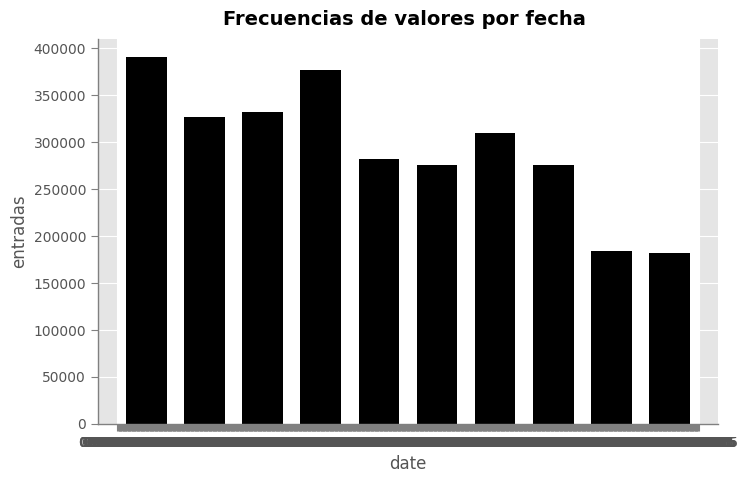

In [ ]:
hist_plot(sales_train, "date",
          title="Frecuencias de valores por fecha ",
          xlabel="date", ylabel="entradas",
          figsize=(8,5), color="black")

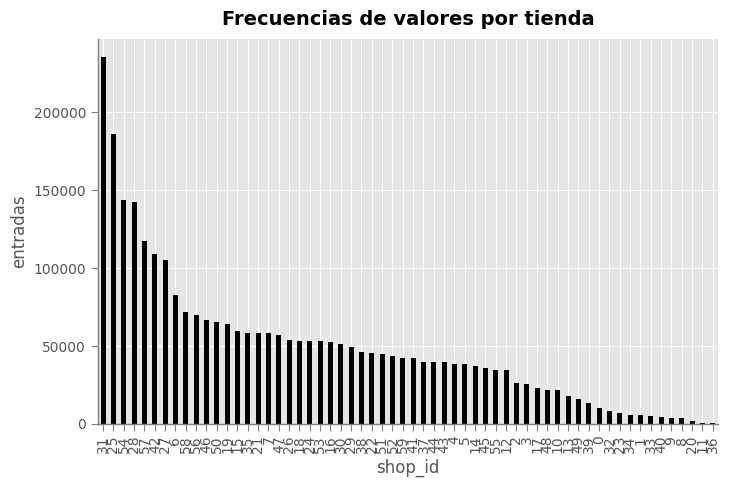

In [ ]:
minimal_bar_plot(sales_train, "shop_id",
          title="Frecuencias de valores por tienda",
          xlabel="shop_id", ylabel="entradas",
          figsize=(8,5), color="black")

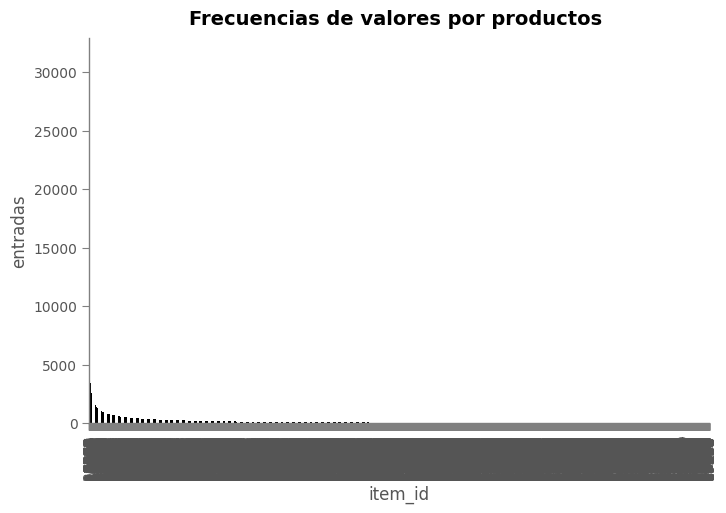

In [ ]:
minimal_bar_plot(sales_train, "item_id",
          title="Frecuencias de valores por productos ",
          xlabel="item_id", ylabel="entradas",
          figsize=(8,5), color="black")

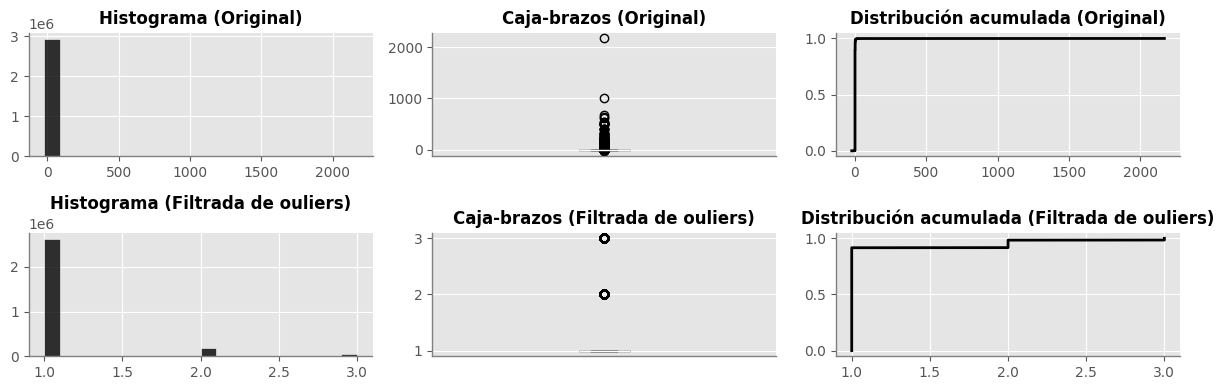

In [ ]:
distribution_plots(sales_train, "item_cnt_day", bins=20, figsize=(12, 4))

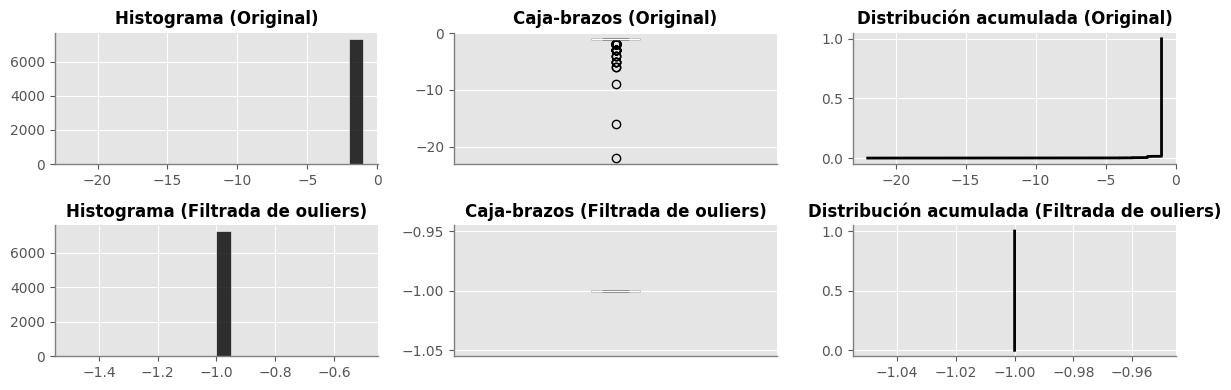

In [ ]:
distribution_plots(sales_train[sales_train["item_cnt_day"] < 0], "item_cnt_day", bins=20, figsize=(12, 4))

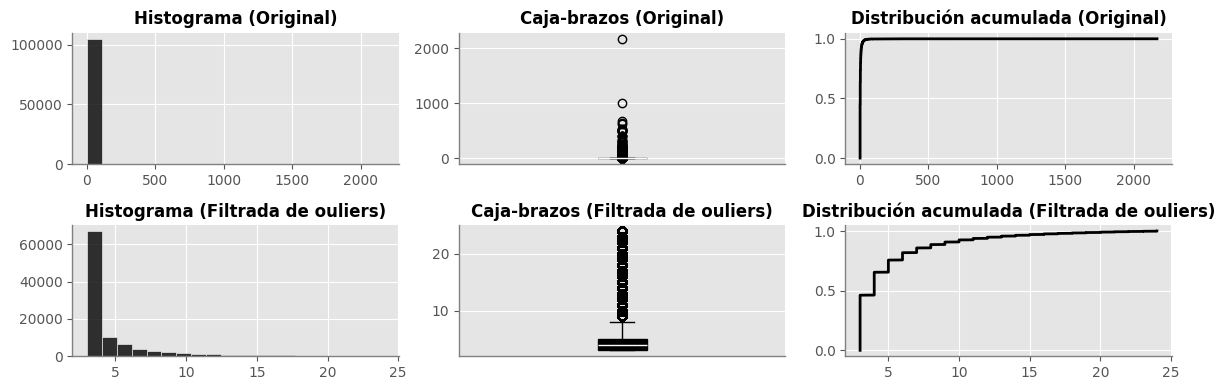

In [ ]:
distribution_plots(sales_train[sales_train["item_cnt_day"] > 2], "item_cnt_day", bins=20, figsize=(12, 4))

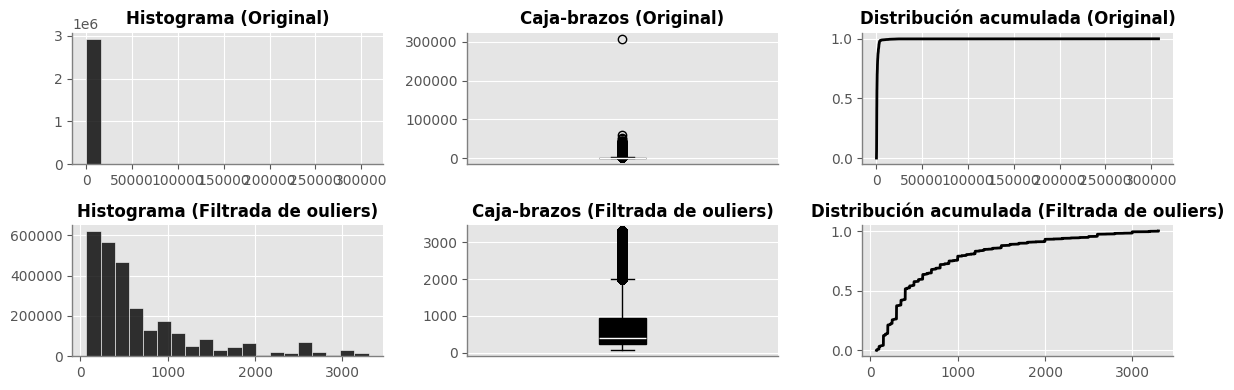

In [ ]:
distribution_plots(sales_train, "item_price", bins=20, figsize=(12, 4))

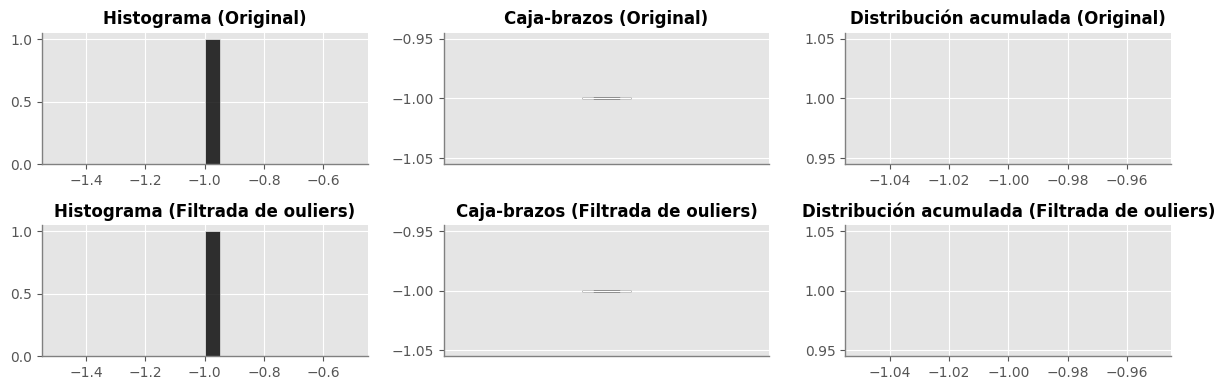

In [ ]:
distribution_plots(sales_train[sales_train["item_price"] < 0], "item_price", bins=20, figsize=(12, 4))

In [ ]:
# Transformamos el campo date a formato Datetime

sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

In [ ]:
# Generamos una tabla auxiliar de ventas por fecha y tienda

sales_per_store = sales_train.pivot_table(
    index = 'date',
    columns = 'shop_id',
    values = 'item_cnt_day',
    aggfunc = np.sum
).fillna(0)

<ipython-input-399-9791f00de8d5>:3: FutureWarning: The provided callable <function sum at 0x7cd8e3f204a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sales_per_store = sales_train.pivot_table(


In [ ]:
# Generamos una tabla auxiliar de ventas por fecha y producto


sales_per_product = sales_train.pivot_table(
    index = 'date',
    columns = 'item_id',
    values = 'item_cnt_day',
    aggfunc = np.sum
).fillna(0)

<ipython-input-398-08b370702ac7>:4: FutureWarning: The provided callable <function sum at 0x7cd8e3f204a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sales_per_product = sales_train.pivot_table(


<Axes: title={'center': 'Media de ventas por tienda y fecha'}, xlabel='date', ylabel='Productos vendidos'>

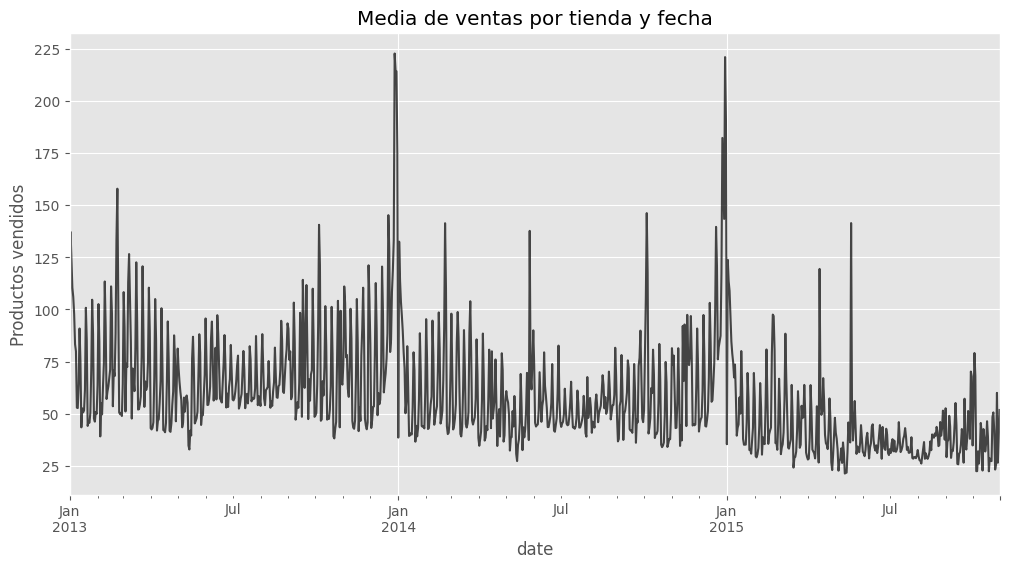

In [ ]:
# Graficamos la media de objetos vendidos por tienda y fecha
sales_per_store.mean(axis = 1).plot(color = 'black',
                                      title = 'Media de ventas por tienda y fecha',
                                      ylabel = 'Productos vendidos',
                                      xlabel = 'date',
                                      alpha = 0.7,
                                      figsize=(12,6))

<Axes: title={'center': 'Media de ventas por producto y fecha'}, xlabel='date', ylabel='Productos vendidos'>

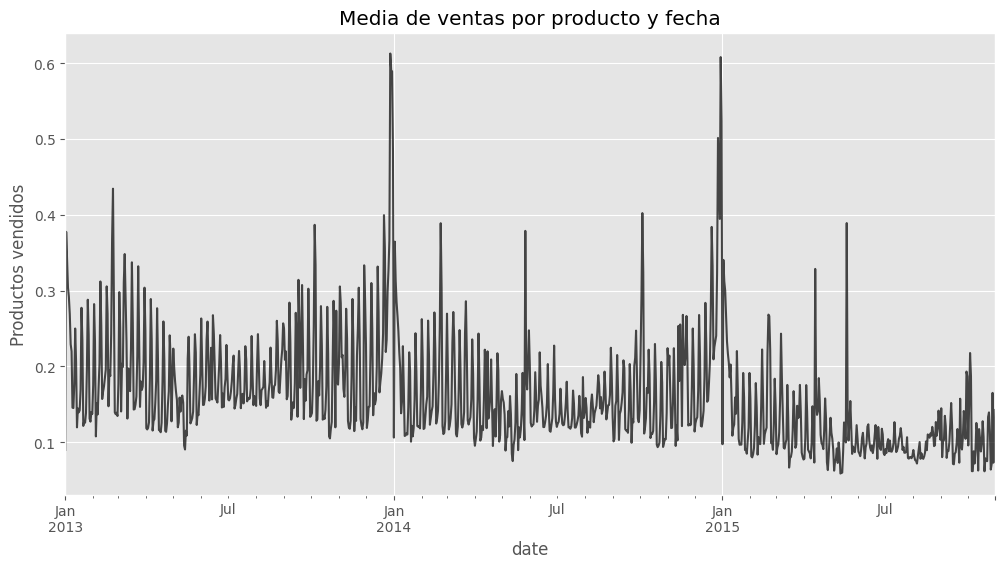

In [ ]:
# Graficamos la media de objetos vendidos por tienda y producto


sales_per_product.mean(axis = 1).plot(color = 'black',
                                      title = 'Media de ventas por producto y fecha',
                                      ylabel = 'Productos vendidos',
                                      xlabel = 'date',
                                      alpha = 0.7,
                                      figsize=(12,6))

In [ ]:
sales_per_price = sales_train.pivot_table(
    index = ['date','shop_id','item_id', 'item_price'],
    values = 'item_cnt_day',
    aggfunc = np.sum
).fillna(0).reset_index()

<ipython-input-71-cf171eb50992>:1: FutureWarning: The provided callable <function sum at 0x7cd8e3f204a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sales_per_price = sales_train.pivot_table(


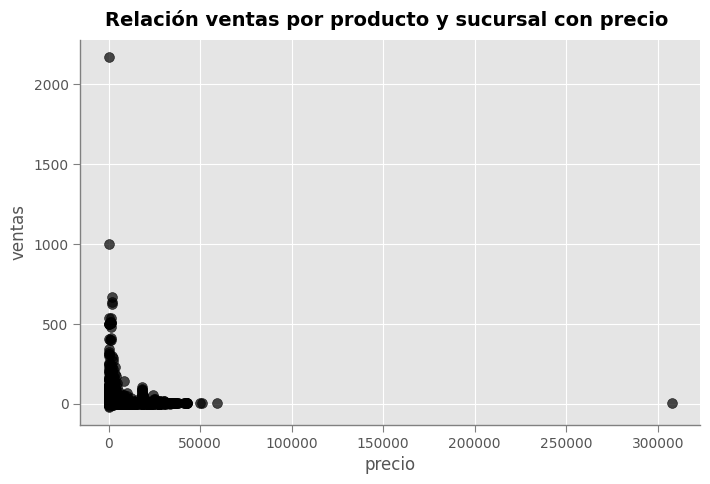

In [ ]:
scatter_plot(sales_per_price, "item_price", "item_cnt_day",
             title="Relación ventas por producto y sucursal con precio ",
             xlabel="precio", ylabel="ventas",
             figsize=(8, 5), color="black", alpha=0.7, size=50)

<ipython-input-404-f275f531263b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  scatter_plot(sales_per_price[sales_per_price['item_price']> 0][sales_per_price['item_cnt_day']> 0]


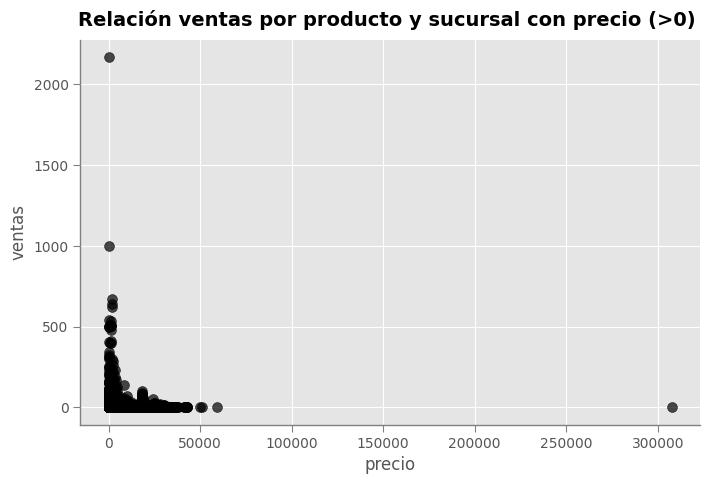

In [ ]:
scatter_plot(sales_per_price[sales_per_price['item_price']> 0][sales_per_price['item_cnt_day']> 0]
             , "item_price", "item_cnt_day",
             title="Relación ventas por producto y sucursal con precio (>0) ",
             xlabel="precio", ylabel="ventas",
             figsize=(8, 5), color="black", alpha=0.7, size=50)

### Coclusión

Los resultados de la exploración de datos nos permite realizar algunas conlusiones preliminares queguiaran el modelado y selección de métodos:

* Gran parte de las ventas diarias se reducen a 1 o a lo más dos artículos de un item en una tienda en particular, con bastantes outliers.

* La mayor parte de los precios (99.99%) se encuentra por debajo de 3000, y gran parte incluso por debajo de 2000.

* Las ventas promedio muestran comportamientos ciclicos.

* El precios contra cantidad parecen mantener una relación cuadrática inversa muy débil.







## Ingeniería de caracteristicas

In [ ]:
# Generamos un dataframe con caracteristicas nuevas
df_monthly = creacion_caracteristicas(sales_train)

# Guardamos datos
df_monthly.to_csv(FEATURES_FILE_NAME, index=False)

print(f"Feature engineering completado. Archivo guardado como '{FEATURES_FILE_NAME}'.")

Feature engineering completado. Archivo guardado como 'sales_features.csv'.


## Selección de Variables

In [ ]:
df_monthly.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_9,...,item_cnt_roll_mean_3,item_cnt_roll_std_3,item_avg_price,item_price_change,item_price_deviation,month,year,season,shop_avg_sales,item_avg_sales
0,0,0,32,4.0,221.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,258.884889,0.0,-37.884889,0,0,0,5.433929,4.321839
1,0,0,98,14.0,268.0,0.0,0.0,0.0,0.0,0.0,...,14.0,0.0,365.750000,0.0,-97.750000,0,0,0,5.433929,9.250000
2,0,0,556,7.0,90.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,169.272727,0.0,-79.272727,0,0,0,5.433929,2.818182
3,0,0,651,2.0,90.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,132.909091,0.0,-42.909091,0,0,0,5.433929,2.000000
4,0,0,677,2.0,90.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,131.300000,0.0,-41.300000,0,0,0,5.433929,2.500000


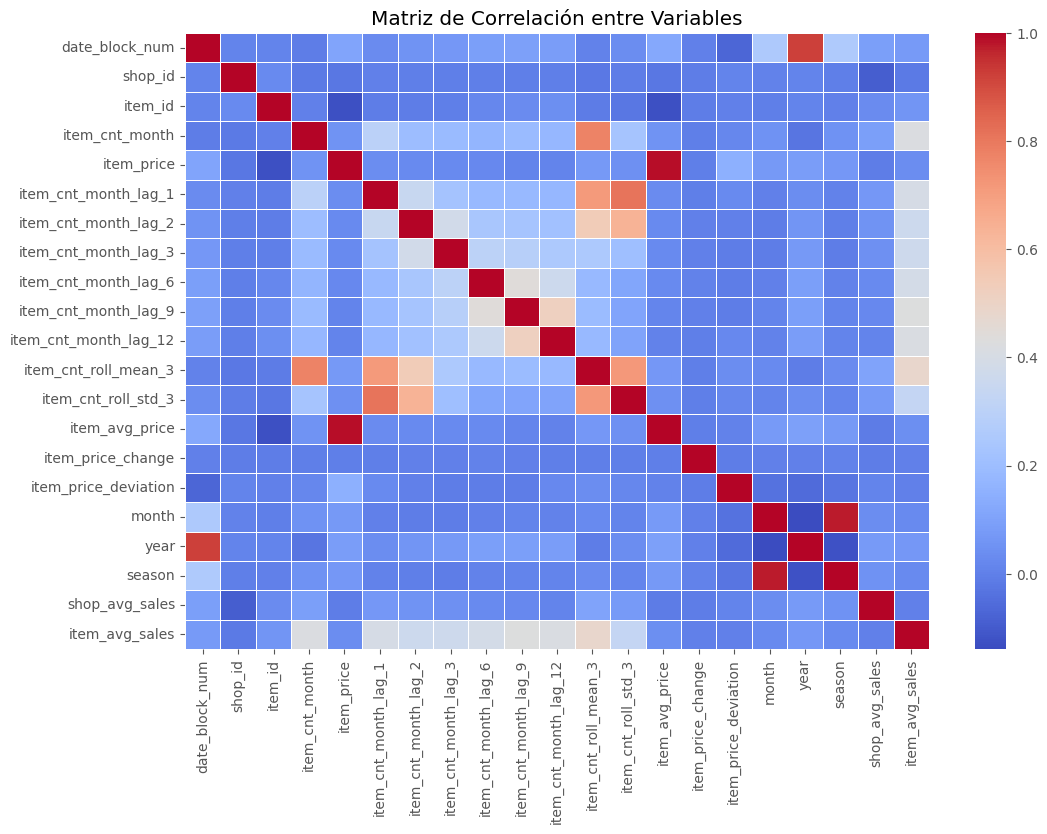

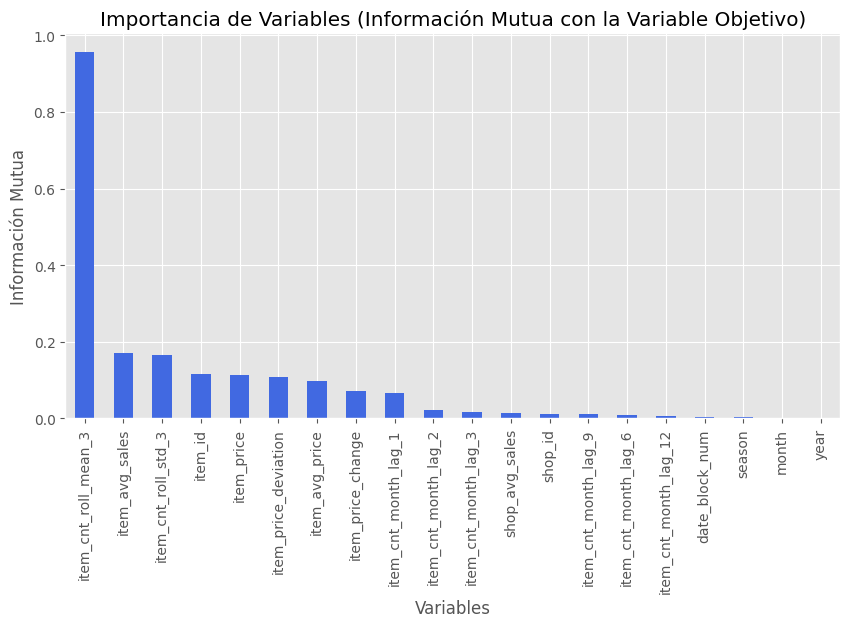

['item_cnt_roll_mean_3',
 'item_avg_sales',
 'item_cnt_roll_std_3',
 'item_id',
 'item_price',
 'item_price_deviation',
 'item_price_change',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'shop_avg_sales',
 'shop_id',
 'item_cnt_month_lag_9']

In [ ]:
# DataFrame auxiliar
df = df_monthly.copy()

# Definir las variables predictoras y la variable objetivo
features = [col for col in df.columns if col not in ["item_cnt_month"]]
target = "item_cnt_month"

X = df[features]
y = df[target]
y = np.log1p(y)

# Matriz de correlación entre variables numéricas
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()

# Información mutua entre características y la variable objetivo
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Importancia de cada variable según su información mutua
plt.figure(figsize=(10, 5))
mi_scores.plot(kind="bar", color="royalblue")
plt.title("Importancia de Variables (Información Mutua con la Variable Objetivo)")
plt.ylabel("Información Mutua")
plt.xlabel("Variables")
plt.xticks(rotation=90)
plt.show()

# Selección de variables basadas en correlación y entropía
# Eliminamos variables altamente correlacionadas (threshold > 0.85)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper.columns if any(upper[column] > 0.85)]

# Selección final de características usando información mutua
selected_features = mi_scores[mi_scores > 0.01].index.tolist()  # Umbral de 0.01 en información mutua
selected_features = [feat for feat in selected_features if feat not in high_correlation_features]

# Mostrar las características seleccionadas
selected_features

## Entrenamiento y evaluación

In [ ]:
# Guardamos en una variable la lista de caracteristicas más útiles
selected_features = ['item_cnt_roll_mean_3', 'item_cnt_roll_std_3', 'item_avg_sales', 'item_price_deviation', 'item_id', 'item_cnt_month_lag_1', 'item_price', 'item_price_change', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'shop_avg_sales', 'shop_id']
selected_features.append("date_block_num")

Entrenando el modelo LightGBM...
Error RMSE en test: 0.0095


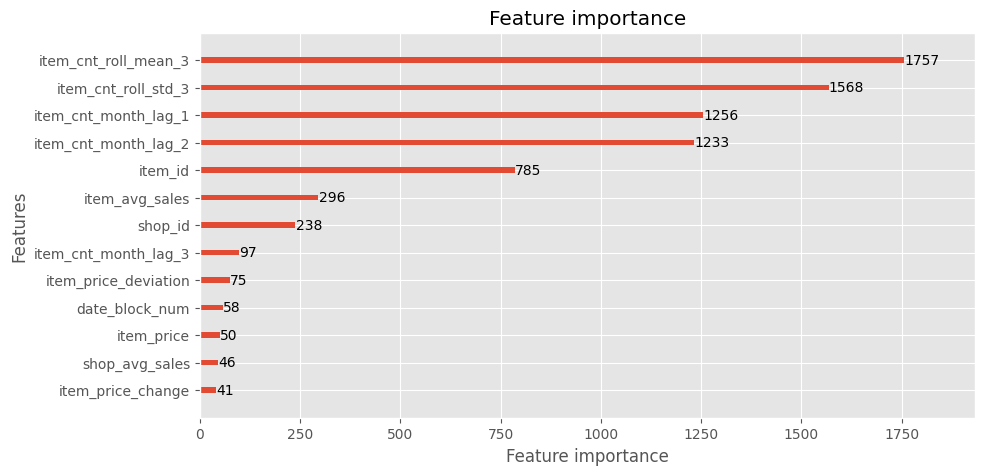

In [ ]:
# copiamos el dataframe con caracteristicas
df = df_monthly.copy()

# Hacemos las llaves categoricas
df["shop_id"] = df["shop_id"].astype("category")
df["item_id"] = df["item_id"].astype("category")

# Definimos las variables independientes (X) y la variable objetivo (y)
features = [col for col in df.columns if col in selected_features]  # Variables predictoras
target = "item_cnt_month"  # Variable objetivo

X = df[features]
y = df[target]
y = np.log1p(y)


# Dividimos el conjunto de entrenamiento y prueba
# Asegurar que los datos están ordenados por tiempo (por seguridad)
df = df.sort_values(by=["date_block_num"])

# Definimos el mes de corte (últimos 20% de los meses en test)
unique_months = df["date_block_num"].unique()
split_point = int(len(unique_months) * 0.8)  # 80% de los meses para entrenamiento
train_months = unique_months[:split_point]  # Meses en entrenamiento
test_months = unique_months[split_point:]  # Meses en prueba

# Dividimos los datos sin mezcla de meses entre train y test
X_train = X[X["date_block_num"].isin(train_months)]
y_train = y[X["date_block_num"].isin(train_months)]

X_test = X[X["date_block_num"].isin(test_months)]
y_test = y[X["date_block_num"].isin(test_months)]

# Verificar la distribución de meses en cada conjunto
train_months_unique = X_train["date_block_num"].unique()
test_months_unique = X_test["date_block_num"].unique()

# Mostrar los resultados de la separación
train_months_unique, test_months_unique

# Especificamos las categoricas
categorical_features = ["shop_id", "item_id"]

# Configuramos para lgb
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Definimos los hiperparámetros de LightGBM
params = {
    "objective": "regression",  # Predicción de clasificación
    "metric": "rmse",  # Usamos el error cuadrático medio
    "boosting_type": "gbdt",  # Gradient Boosting Decision Trees
    "learning_rate": 0.05,  # Tasa de aprendizaje
    "num_leaves": 31,  # Número de hojas en cada árbol
    "feature_fraction": 0.8,  # Fracción de características utilizadas por iteración
    "bagging_fraction": 0.8,  # Fracción de datos usados en cada iteración
    "bagging_freq": 5,  # Cada cuántas iteraciones se hace bagging
    "verbose": -1  # No mostrar logs innecesarios
}

# Entrenamos
print("Entrenando el modelo LightGBM...")
model = lgb.train(params, train_data, valid_sets=[test_data],num_boost_round = 250)

# Evaluamos el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"Error RMSE en test: {rmse:.4f}")

# Imprimimos la importancia de las variables
lgb.plot_importance(model, max_num_features=15, figsize=(10, 5))
plt.show()

In [ ]:
# Guardar el modelo entrenado en un archivo
model.save_model(MODEL_FILE_NAME)


In [ ]:
from google.colab import files
files.download(MODEL_FILE_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Producto (Ejemplo de uso)

In [ ]:
# Generamos el Inventario
shop_ids = sales_train.shop_id.drop_duplicates().sort_values().tolist()
item_ids = sales_train.item_id.drop_duplicates().sort_values().tolist()

# Configuramos los inputs dinamicos
shop_input = widgets.Dropdown(options=shop_ids, description="Shop ID:")
item_input = widgets.Dropdown(options=item_ids, description="Item ID:")
price_input = widgets.FloatText(value=1700.49, description="Item Price:")

In [ ]:
# Boton para activar la prediccion
button = widgets.Button(description="Predict Sales")
button.on_click(predict_sales)

# Ejecutamos el UI
display(shop_input, item_input, price_input, button)

Dropdown(description='Shop ID:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

Dropdown(description='Item ID:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

FloatText(value=1700.49, description='Item Price:')

Button(description='Predict Sales', style=ButtonStyle())

Predicción de ventas: 0 unidades (Predicción puntual: 0.3547)
Intervalo de confianza 95%: [0, 6] unidades
Predicción de ventas: 2 unidades (Predicción puntual: 1.9299)
Intervalo de confianza 95%: [0, 8] unidades


### Diagrama de flujo


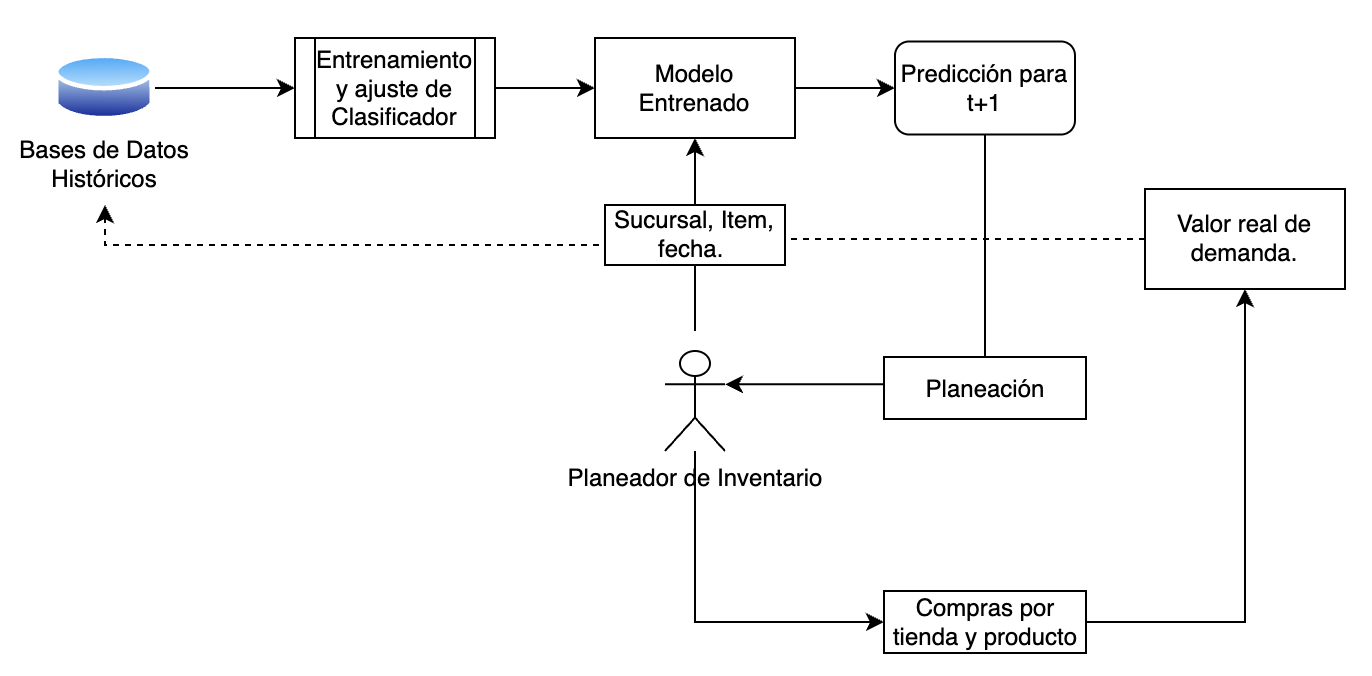